In [205]:
from collections import Counter
import re

from pymongo import MongoClient
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import jieba

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [13]:
client = MongoClient('localhost',32768)


In [15]:
collection_positions = client['zhaopin']['lagou']
collection_job_detail = client['zhaopin']['jobs']
positions = pd.DataFrame(list(collection_positions.find({})))
job_detail = pd.DataFrame(list(collection_job_detail.find({})))

In [17]:
positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1855 entries, 0 to 1854
Data columns (total 52 columns):
_id                      1855 non-null object
positionId               1855 non-null int64
positionName             1855 non-null object
companyId                1855 non-null int64
companyFullName          1855 non-null object
companyShortName         1855 non-null object
companyLogo              1854 non-null object
companySize              1855 non-null object
industryField            1855 non-null object
financeStage             1855 non-null object
companyLabelList         1855 non-null object
firstType                1855 non-null object
secondType               1855 non-null object
thirdType                1855 non-null object
skillLables              1855 non-null object
positionLables           1855 non-null object
industryLables           1855 non-null object
createTime               1855 non-null object
formatCreateTime         1855 non-null object
city                 

In [18]:
#positionId是唯一值，在爬取时可能重复，先去重
data = positions.drop_duplicates(subset=['positionId'])
#选取主要信息列，职位ID、职位名称、公司简称、公司规模、行业领域、财务阶段、城市、区域、商业区、工资、工作年限、工作性质、经纬度
data = data[['positionId', 
             'positionName', 
             'companyShortName', 
             'companySize', 
             'industryField', 
             'financeStage', 
             'city',
             'district',
             'salary',
             'workYear',
             'jobNature',
             'education',
             'latitude',
             'longitude'
            ]]
#只分析全职信息,筛除无关信息-讲师、老师
data = data[data['jobNature']=='全职']
dorp_index=data[data['positionName'].isin(['Python数据分析及机器学习讲师','数据分析（量化金融）课程老师（常州）'])].index
data.drop(dorp_index,inplace=True)

In [58]:
def word_level(x):
    lvA = r'总监'
    lvB = r'高级|资深|经理|主管|负责人|主任|leader|专家|Lead'
    lvC = r'分析师|工程师|建模师|技术员|顾问|分析岗|分析$|运营师'
    lvD = r'助理|专员|培训生|管培生'
    lvE = r'实习'
    if re.search(lvA,x):
        return '总监'
    elif re.search(lvB,x):
        return '主管'
    elif re.search(lvE, x):
        return '实习'
    elif re.search(lvD, x):
        return '助理'
    else:
        return '专员'
    

data['job_level']=data['positionName'].apply(word_level)

In [90]:
temp=data.apply(lambda x : pd.Series(re.split(r'\丨|,| ', x['industryField'])), 
                axis=1).rename(columns={0:'indu_1',
                                        1:'indu_2',
                                        2:'indu_3'})
data = pd.concat([data, temp], axis=1)


In [100]:
#工资数据处理
data=data.join(data.apply(lambda x : re.findall(r'\d+',x['salary']), result_type='expand', axis=1).rename(columns={0:'salary_min',
                                                                                                   1:'salary_max'}))

data['salary_min'] = data['salary_min'].astype('int')
data['salary_max'] = data['salary_max'].astype('int')
data['salary_mean'] = (data['salary_max'] + data['salary_min'])/2

# 描述分析  
## 数据分析岗位城市、城区分布
## 数据分析岗位行业分布
## 数据分析岗位职级分布
## 数据分析岗位

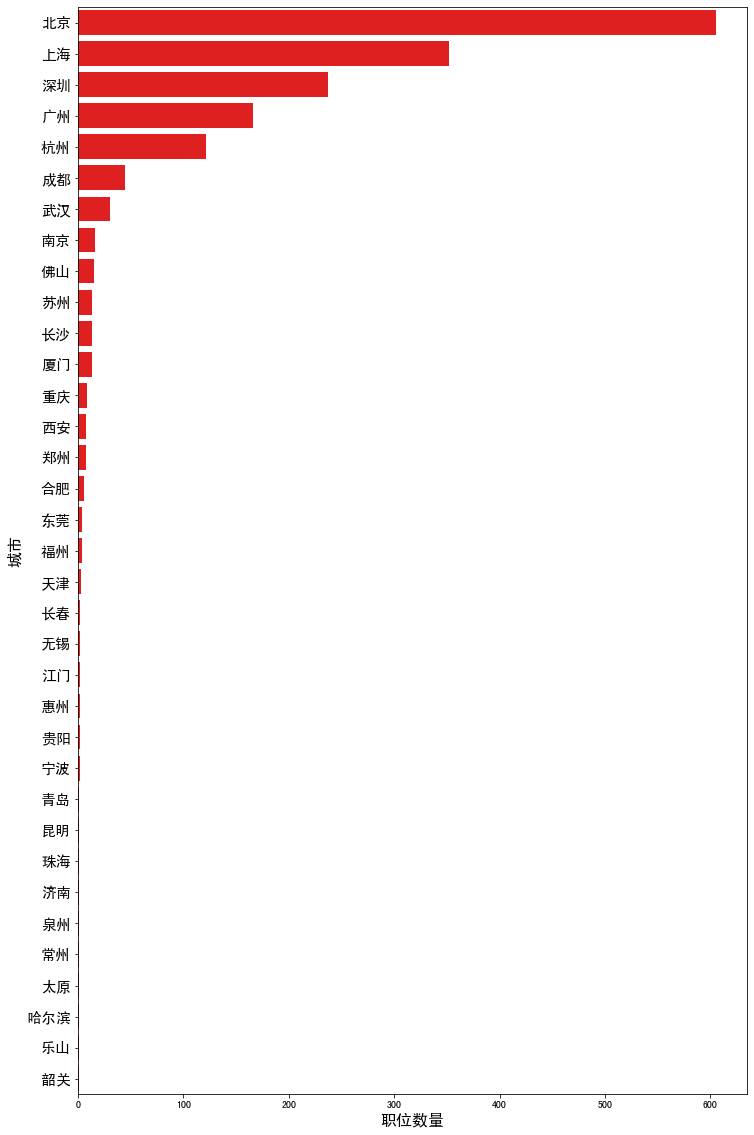

In [123]:
temp = data.groupby(['city'])['city'].agg([('职位数量', 'count')]).reset_index().sort_values(by=['职位数量'], ascending=False)
f, ax=plt.subplots(figsize=(12,20))
sns.barplot(y='city',x='职位数量',data=temp,orient='h', color='red')
plt.ylabel('城市', fontsize=16)
plt.xlabel('职位数量', fontsize=16)
plt.xticks(rotation='horizontal')
plt.yticks(fontsize=15)
plt.show()

In [163]:
#选取职位数量前10位城市做描述性分析，北京、上海、深圳、广州、杭州、成都、武汉、南京、佛山、苏州
city_list = ['北京', '上海', '深圳', '广州', '杭州', '成都', '武汉', '南京', '佛山', '苏州']
data = data[data['city'].isin(city_list)]


In [221]:
def data_plot(data, x, y, xlabel, ylabel):
    f, ax=plt.subplots(figsize=(12,20))
    sns.barplot(y=y, x=x, data=data, orient='h', color='red')
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.xticks(rotation='horizontal')
    plt.yticks(fontsize=15)
    plt.show()

In [215]:
#数据分析城区聚集情况
data.groupby(['district'])['district'].agg([('职位数量', 'count')]).reset_index().sort_values(by=['职位数量'], ascending=False).head(15)

,district,职位数量
38,海淀区,283
25,朝阳区,232
6,南山区,170
14,天河区,85
37,浦东新区,84
20,徐汇区,63
60,长宁区,46
2,东城区,43
55,西湖区,42
5,余杭区,36


In [142]:
#数据分析职位的职级
data.groupby(['job_level'])['job_level'].agg([('职位数量', 'count')]).reset_index().sort_values(by=['职位数量'], ascending=False)

,job_level,职位数量
0,专员,1146
1,主管,441
2,助理,70
3,实习,25
4,总监,9


In [143]:
#工资分布（以工资范围最小值计算,单位：k）
data['salary_min'].describe()

count    1691.000000
mean       14.705500
std         6.917149
min         1.000000
25%        10.000000
50%        15.000000
75%        20.000000
max        50.000000
Name: salary_min, dtype: float64

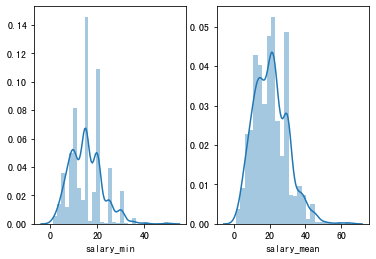

In [210]:
f, ax = plt.subplots(1,2)
sns.distplot(data['salary_min'], ax=ax[0])
sns.distplot(data['salary_mean'], ax=ax[1])

In [212]:
data.groupby(['city'])['salary_min','salary_mean'].agg([('薪酬中位数', 'median')]).reset_index()

,city,salary_min,salary_mean
,,薪酬中位数,薪酬中位数
0,上海,15,20.00
1,佛山,11,16.50
2,北京,15,22.50
3,南京,10,12.50
4,广州,10,12.50
5,成都,8,11.50
6,杭州,15,20.00
7,武汉,9,12.25
8,深圳,15,20.00


In [165]:
data.groupby(['city', 'workYear'])['salary_mean'].agg([('薪酬中位数', 'median')])#.reindex(city_list)

薪酬中位数
city workYear       
上海   1-3年      16.00
     10年以上     40.00
     1年以下      13.25
     3-5年      22.50
     5-10年     30.00
     不限        12.50
     应届毕业生     12.00
佛山   1-3年      14.75
     1年以下      11.50
     3-5年      16.50
     5-10年     11.50
北京   1-3年      19.00
     10年以上     40.00
     1年以下       7.50
     3-5年      22.50
     5-10年     30.00
     不限        20.00
     应届毕业生     10.00
南京   1-3年      12.50
     3-5年      17.50
     5-10年     20.00
     不限        13.00
     应届毕业生     12.50
广州   1-3年      10.50
     1年以下       8.00
     3-5年      17.00
     5-10年     22.50
     不限        12.50
     应届毕业生      7.25
成都   1-3年       9.00
     1年以下       6.00
     3-5年      15.00
     5-10年     12.50
     不限         8.75
     应届毕业生      6.00
杭州   1-3年      12.00
     10年以上     33.75
     1年以下       5.50
     3-5年      20.00
     5-10年     30.00
     不限        19.00
     应届毕业生     13.50
武汉   1-3年       6.50
     3-5年      18.25
     5-10年     21.25
     不限         7.00
     应届毕业生     10.75
深圳   1-3年      15.00
     1年以下      15.00
     3-5年      22.50
     5-10年     30.00
     不限        10.00
     应届毕业生      8.50
苏州   1-3年       8.50
     1年以下       5.00
     3-5年      20.00
     5-10年     30.00

In [224]:
#前15薪酬行业
temp=data.groupby(['indu_1'])['salary_mean'].agg([('薪酬中位数', 'median')]).sort_values(by=['薪酬中位数'], ascending=False).reset_index()

In [225]:
temp.tail(10)


,indu_1,薪酬中位数
17,医疗,16.25
18,游戏,16.00
19,企业服务,15.00
20,数据服务,15.00
21,信息安全,15.00
22,软件开发,15.00
23,广告营销,9.00
24,其他,8.00
25,通讯电子,8.00
26,数据服务、金融,3.50


In [202]:
indulist = temp.hea(15).index.to_list()
data[data['indu_1'].isin(indulist)].groupby(['indu_1','workYear'])['salary_mean'].agg([('薪酬中位数', 'median')]).reset_index().sort_values(by=['indu_1','薪酬中位数'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

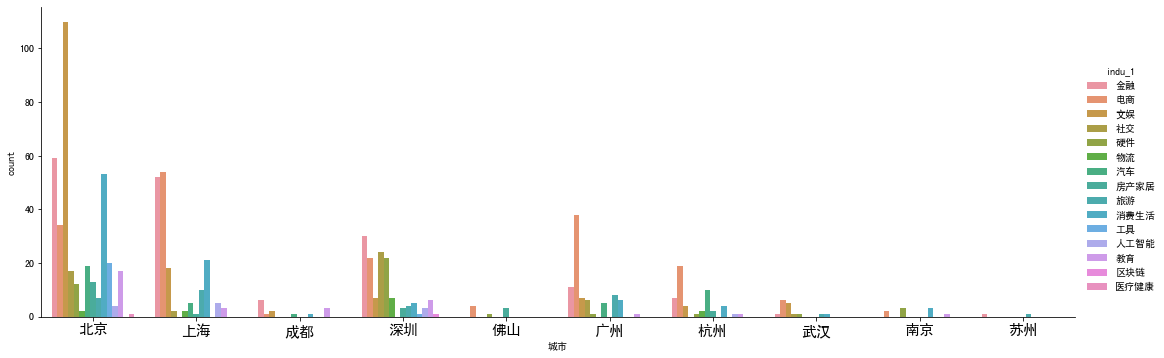

In [208]:
sns.catplot(x='city',kind='count',hue='indu_1', data=data[data['indu_1'].isin(indulist)], aspect=3.)
plt.xlabel('城市')
plt.xticks(fontsize=15)